In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

# Exploratory analysis

In this notebook we are going to focus on the `Expanded_data/big_data_final.tsv` dataset that is created by running the `data_creation.ipynb` notebook. Please refer to the data creation notebook for any questions concerning the contruction on the dataset that we are using here.

We are going to display some relevant features and some preliminary analysis.

In [3]:
df_movie = pd.read_csv("Expanded_data/big_data_final.tsv",sep='\t')
print(df_movie.shape)
df_movie.head()

C:\Users\lisap\AppData\Local\Temp/ipykernel_14488/1739072153.py:1: DtypeWarning: Columns (0,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movie = pd.read_csv("Expanded_data/big_data_final.tsv",sep='\t')


(9385367, 13)


Freebase movie ID    IMDB_id  Movie box office revenue  \
0       /m/0100_m55  tt0138297                       NaN   
1       /m/0100_mnm  tt0202813                       NaN   
2       /m/0100_nzr  tt0184302                       NaN   
3       /m/0100_pgp  tt0094831                       NaN   
4       /m/0100_pz9  tt0088884                       NaN   

     Movie genres names     Movie name  Movie release date  averageRating  \
0  ['Comedy', 'Sci-Fi']  Urban Animals              1987.0            5.2   
1            ['Comedy']            NaN              1999.0            5.8   
2             ['Drama']            NaN              1999.0            4.8   
3            ['Comedy']            NaN              1988.0            6.8   
4            ['Comedy']            NaN              1985.0            2.4   

   budget  numVotes prod_country  inflation coeff  \
0     NaN      79.0          NaN         2.384772   
1     NaN      15.0          NaN         1.626713   
2     NaN     119.0          NaN         1.626713   
3     NaN     103.0          NaN         2.291337   
4     NaN      59.0          NaN         2.519087   

   inflation corrected revenue  inflation corrected budget  
0                          NaN                         NaN  
1                          NaN                         NaN  
2                          NaN                         NaN  
3                          NaN                         NaN  
4                          NaN                         NaN

### Genre distribution

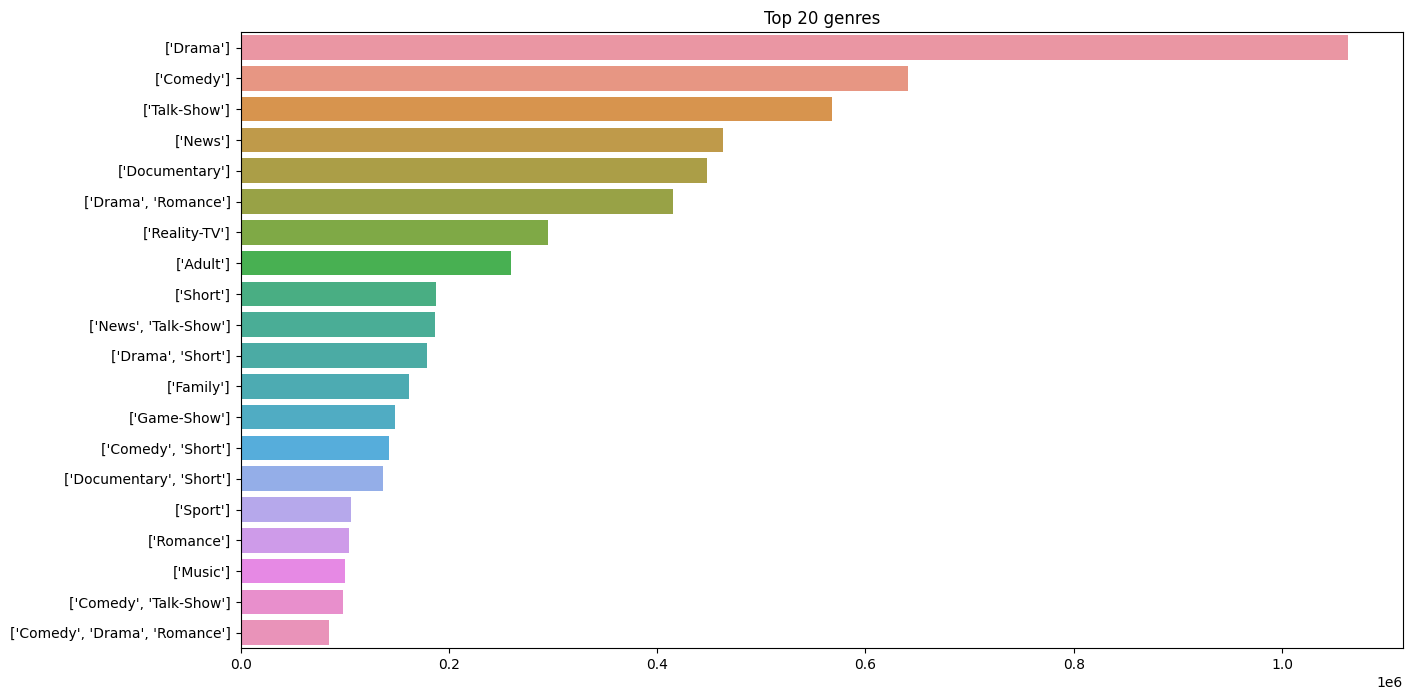

In [3]:
df_genre = df_movie.copy()
df_genre.dropna(subset=['Movie genres names'], inplace=True)

count_genre = df_genre['Movie genres names'].value_counts()

plt.figure(figsize=(15,8))
ax = sns.barplot(x=count_genre.values[0:20], y=count_genre.index[0:20]).set(title='Top 20 genres')
plt.show()

### Year distribution

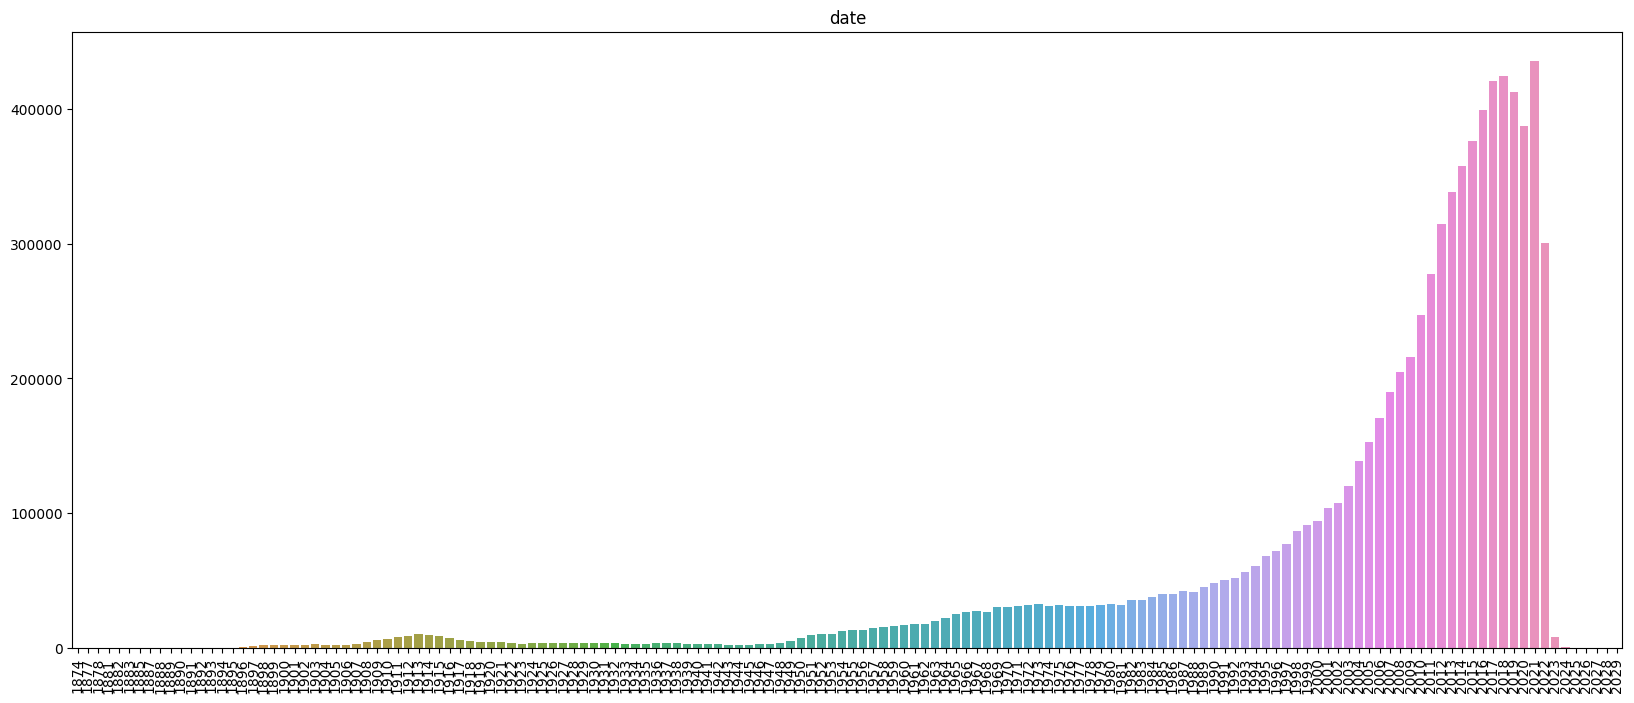

In [8]:
df_date = df_movie[~df_movie['Movie release date'].isna()]

count_per_year = df_date['Movie release date'].value_counts()
plt.figure(figsize=(20,8))
ax = sns.barplot(x=count_per_year.index.astype('int64'), y=count_per_year.values).set(title='date')
plt.xticks(rotation='vertical')
plt.show()

In [9]:
print(count_per_year[1896])
print(count_per_year[1897])
print(count_per_year[2023])
print(count_per_year[2024])

# 1897 : more than 1000 movies until 2023

900
1372
8291
442


### Genre per year

In [ ]:
#remove nan
df_genre_date = df_date[~df_date['genre1'].isna()]
#remove '\N' 
df_genre_date = df_genre_date[df_genre_date.genre1 != "\\N"]

MemoryError: Unable to allocate 296. MiB for an array with shape (5, 7753778) and data type object

In [ ]:
df_genre_date.groupby(['Movie release year', 'genre1']).size().unstack().plot(kind='bar', stacked=True)
#illisible

In [ ]:
# Plot relative number of genres per year

cross_tab_prop = pd.crosstab(index=df_genre_date['Movie release year'],
                             columns=df_genre_date['genre1'],
                             normalize="index")
cross_tab_prop

In [ ]:
cross_tab = pd.crosstab(index=df_genre_date['Movie release year'],
                        columns=df_genre_date['genre1'])
cross_tab

In [ ]:
cross_tab_prop.plot(kind='bar', 
                    stacked=True,  
                    figsize=(50, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Movie release year")
plt.ylabel("Proportion")
plt.show()

#### Genre per year (retirer valeurs rares)

In [ ]:
# Reduce number of genres (otherwise not lisibe on the graphs)
thr_genre = 300000 #minimal number of movies with a certain genre

# Select the values where the count is less than 3 (or 5 if you like)
to_remove = count_genre[count_genre <= thr_genre].index

# Keep rows where the city column is not in to_remove
df_genre_date_thr = df_genre_date[~df_genre_date.genre1.isin(to_remove)]

In [ ]:
# print only from 1897 (more than 1000 movies)
df_genre_date_thr = df_genre_date_thr[df_genre_date_thr['Movie release year']>=1897]
df_genre_date_thr = df_genre_date_thr[df_genre_date_thr['Movie release year']<=2023]

cross_tab_prop = pd.crosstab(index=df_genre_date_thr['Movie release year'],
                             columns=df_genre_date_thr['genre1'],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True,
                    colormap='tab20',
                    figsize=(50, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Movie release year")
plt.ylabel("Proportion")
plt.show()

# Rating, Revenue and Budget
To determine the success of a movie, we want to consider the box office revenue, the budget and the rating. Therefore, we have to analyse the relationship between these features.
The budgets and the revenues are corrected by considering the inflation. 

For each year there are several movies and therefore several ratings, revenues and budgets. We decided to average these variables for each year in order to get one single data point for each time point. But the mean hides a dark side, its sensitivity to outliers. This is why we also compute the median values for each of the variable of interest.

### An overview of the distributions

In [176]:
dist = df_movie.copy()
dist = dist.dropna(subset=['inflation corrected budget','inflation corrected revenue','averageRating'])

<AxesSubplot:xlabel='inflation corrected budget', ylabel='Count'>

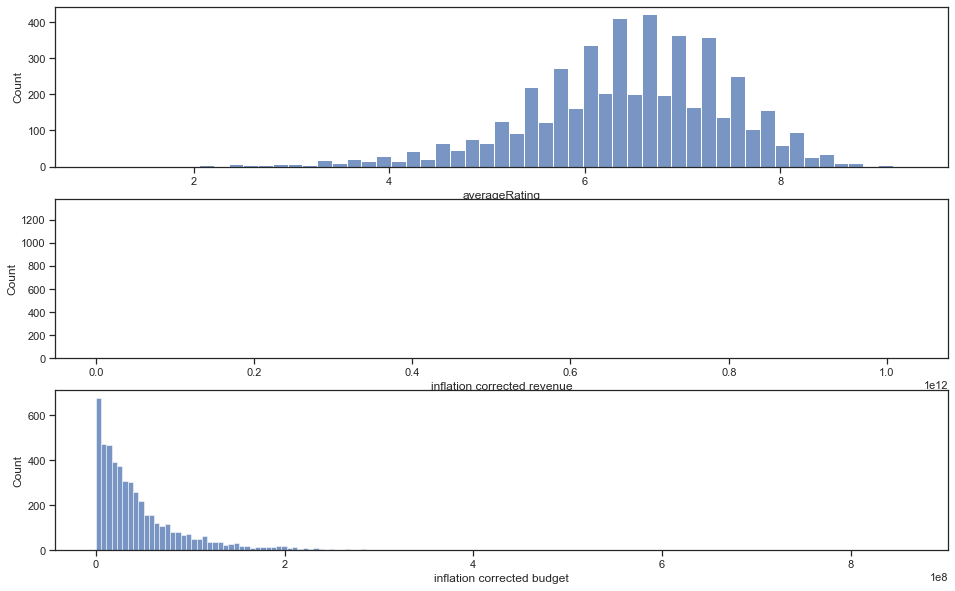

In [180]:
# Plotting
fig, axs = plt.subplots(3,1,figsize=(16,10))
sns.histplot(dist.averageRating,ax=axs[0])
sns.histplot(dist['inflation corrected revenue'],ax=axs[1])
sns.histplot(dist['inflation corrected budget'],ax=axs[2])

In [ ]:
sns.histplot(dist['inflation corrected revenue'])

KeyboardInterrupt: 

### An overview of revenue and budget with and without inflation

In [175]:
budget = df_movie.copy()
budget = budget.dropna(subset=['budget', 'inflation corrected budget'])

In [170]:
years = np.sort(budget['Movie release date'].unique())
mean_budget = np.zeros_like(years)
mean_budget_inf = np.zeros_like(years)
median_budget = np.zeros_like(years)
median_budget_inf = np.zeros_like(years)

for i,y in enumerate(years):
    
    bud = budget.loc[budget['Movie release date'] == y]['budget']
    bud_inf = budget.loc[budget['Movie release date'] == y]['inflation corrected budget']
    
    mean = np.mean(bud)
    median = np.median(bud)
    mean_budget[i] = mean
    median_budget[i] = median
    
    mean = np.mean(bud_inf)
    median = np.median(bud_inf)
    mean_budget_inf[i] = mean
    median_budget_inf[i] = median

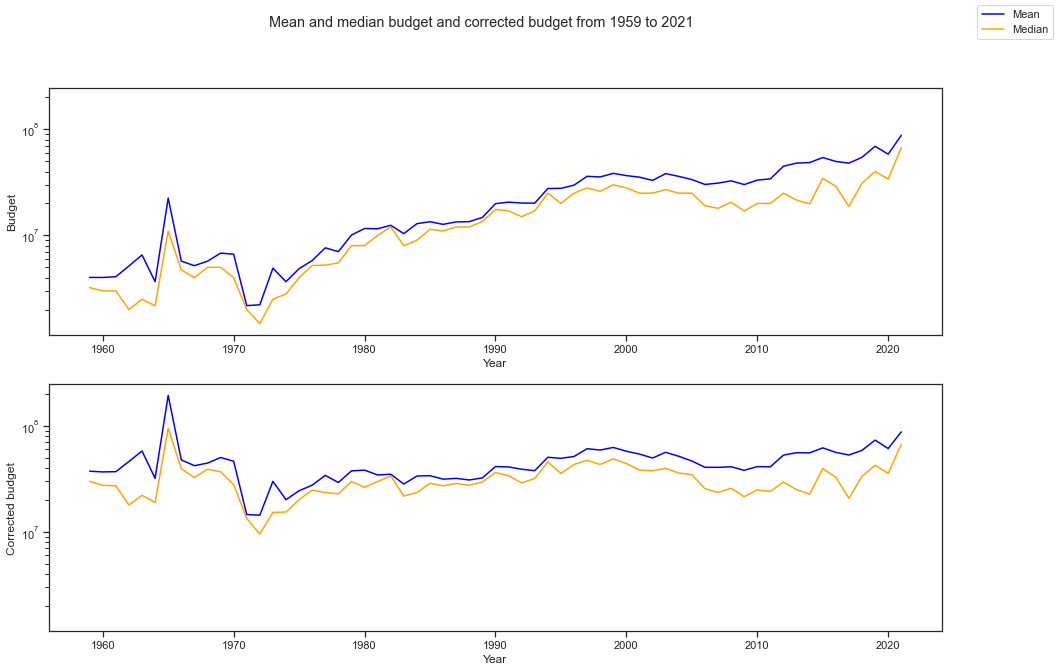

In [171]:
# Plotting
fig, ax = plt.subplots(2,1,figsize=(16,10),sharey=True)

ax[0].plot(years,mean_budget, color = 'blue', label='Mean')
ax[0].plot(years,median_budget, color = 'orange', label='Median')

ax[1].plot(years,mean_budget_inf, color = 'blue')
ax[1].plot(years,median_budget_inf, color = 'orange')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_ylabel('Budget')
ax[1].set_ylabel('Corrected budget')
ax[0].set_xlabel('Year')
ax[1].set_xlabel('Year')
plt.suptitle('Mean and median budget and corrected budget from 1959 to 2021')
fig.legend()
plt.show()

In [152]:
revenue = df_movie.copy()
revenue = revenue.dropna(subset=['Movie box office revenue', 'inflation corrected revenue'])

In [155]:
years = np.sort(revenue['Movie release date'].unique())
mean_revenue = np.zeros_like(years)
mean_revenue_inf = np.zeros_like(years)
median_revenue = np.zeros_like(years)
median_revenue_inf = np.zeros_like(years)

for i,y in enumerate(years):
    
    rev = revenue.loc[revenue['Movie release date'] == y]['Movie box office revenue']
    rev_inf = revenue.loc[revenue['Movie release date'] == y]['inflation corrected revenue']
    
    mean = np.mean(rev)
    median = np.median(rev)
    mean_revenue[i] = mean
    median_revenue[i] = median
    
    mean = np.mean(rev_inf)
    median = np.median(rev_inf)
    mean_revenue_inf[i] = mean
    median_revenue_inf[i] = median

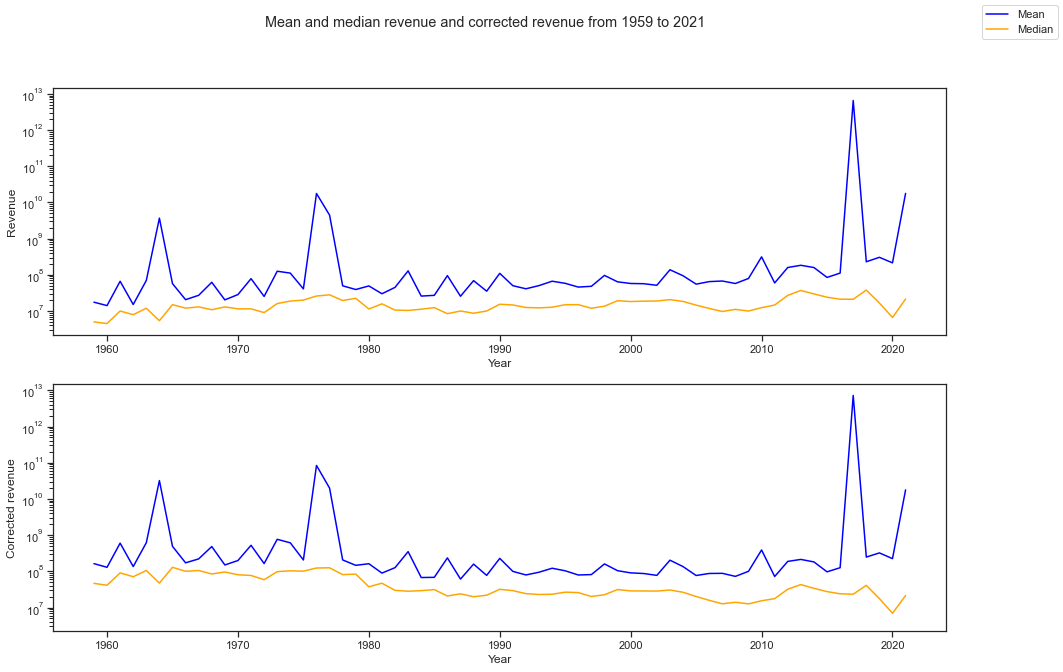

In [173]:
# Plotting
fig, ax = plt.subplots(2,1,figsize=(16,10),sharey=True)

ax[0].plot(years,mean_revenue, color = 'blue', label='Mean')
ax[0].plot(years,median_revenue, color = 'orange', label='Median')

ax[1].plot(years,mean_revenue_inf, color = 'blue')
ax[1].plot(years,median_revenue_inf, color = 'orange')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_ylabel('Revenue')
ax[1].set_ylabel('Corrected revenue')
ax[0].set_xlabel('Year')
ax[1].set_xlabel('Year')
plt.suptitle('Mean and median revenue and corrected revenue from 1959 to 2021')
fig.legend()
plt.show()

### New subsection

In [102]:
# According to discussions in the forum, we calculated the means and the CI
# Create the bootstrap function
def bootstrap(data, n_it):
    means = np.zeros(n_it)
    medians = np.zeros(n_it)
    data = np.array(data)
    
    for n in range(n_it):
        indices = np.random.randint(0, len(data), len(data))
        data_new = data[indices] 
        means[n] = np.nanmean(data_new)
        medians[n] = np.nanmedian(data_new)
    
    # 95% CI -> 2.5% and 97.5%
    return [np.nanmean(means), np.nanmedian(medians), np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5), np.nanpercentile(medians, 2.5),np.nanpercentile(medians, 97.5)]

In [104]:
#Revenue, Rating and Budget
df = df_movie.copy()
df = df.dropna(subset=['inflation corrected revenue', 'averageRating','inflation corrected budget'])

years = np.sort(df['Movie release date'].unique())

rev_mean, rev_median, rev_low, rev_high, rev_low_median, rev_high_median = np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years)
rat_mean, rat_median, rat_low, rat_high, rat_low_median, rat_high_median = np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years)
bud_mean, bud_median, bud_low, bud_high, bud_low_median, bud_high_median = np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years)


for i,y in enumerate(years):
    
    rev_mean[i], rev_median[i], rev_low[i], rev_high[i], rev_low_median[i], rev_high_median[i] = bootstrap(df.loc[df['Movie release date'] == y]['inflation corrected revenue'],1000)
    rat_mean[i], rat_median[i], rat_low[i], rat_high[i], rat_low_median[i], rat_high_median[i] = bootstrap(df.loc[df['Movie release date'] == y]['averageRating'],1000)
    bud_mean[i], bud_median[i], bud_low[i], bud_high[i], bud_low_median[i], bud_high_median[i] = bootstrap(df.loc[df['Movie release date'] == y]['inflation corrected budget'],1000)
    

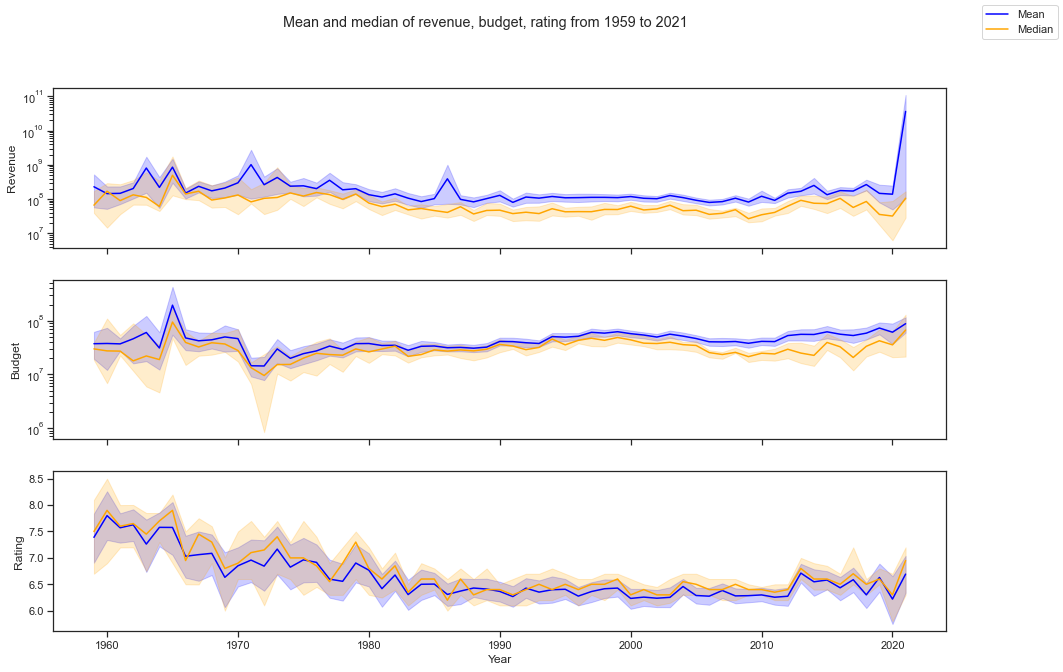

In [134]:
# Plotting
fig, ax = plt.subplots(3,1,figsize=(16,10),sharex=True)

ax[0].fill_between(years, rev_low,rev_high, alpha = 0.2, color = 'blue')
ax[0].plot(years,rev_mean, color = 'blue', label='Mean')

ax[0].fill_between(years, rev_low_median,rev_high_median, alpha = 0.2, color = 'orange')
ax[0].plot(years,rev_median, color = 'orange', label='Median')

ax[0].set_yscale('log')

ax[1].fill_between(years, bud_low,bud_high, alpha = 0.2, color = 'blue')
ax[1].plot(years,bud_mean, color = 'blue')

ax[1].fill_between(years, bud_low_median,bud_high_median, alpha = 0.2, color = 'orange')
ax[1].plot(years,bud_median, color = 'orange')

ax[1].set_yscale('log')

ax[2].fill_between(years, rat_low,rat_high, alpha = 0.2, color = 'blue')
ax[2].plot(years,rat_mean, color = 'blue')

ax[2].fill_between(years, rat_low_median,rat_high_median, alpha = 0.2, color = 'orange')
ax[2].plot(years,rat_median, color = 'orange')


ax[0].set_ylabel('Revenue')
ax[1].set_ylabel('Budget')
ax[2].set_ylabel('Rating')
plt.xlabel('Year')
plt.suptitle('Mean and median of revenue, budget, rating from 1959 to 2021')
fig.legend()
plt.show()

In [3]:
#Revenue vs. Rating
revenue_rating = df_movie.copy()
revenue_rating = revenue_rating.dropna(subset=['inflation corrected revenue', 'averageRating'])

years_rr = revenue_rating['Movie release date'].unique()
mean_revenue_rr = np.zeros_like(years_rr)
median_revenue_rr = np.zeros_like(years_rr)
mean_rating_rr = np.zeros_like(years_rr)
median_rating_rr = np.zeros_like(years_rr)
for i,y in enumerate(years_rr):
    
    rev = revenue_rating.loc[revenue_rating['Movie release date'] == y]['inflation corrected revenue']
    rat = revenue_rating.loc[revenue_rating['Movie release date'] == y]['averageRating']
    
    mean = np.mean(rev)
    median = np.median(rev)
    mean_revenue_rr[i] = mean
    median_revenue_rr[i] = median
    
    mean = np.mean(rat)
    median = np.median(rat)
    mean_rating_rr[i] = mean
    median_rating_rr[i] = median

In [29]:
#Revenue vs. Budget
revenue_budget = df_movie.copy()
revenue_budget = revenue_budget.dropna(subset=['inflation corrected revenue', 'inflation corrected budget'])

years_rb = revenue_budget['Movie release date'].unique()
mean_revenue_rb = np.zeros_like(years_rb)
median_revenue_rb = np.zeros_like(years_rb)
mean_budget_rb = np.zeros_like(years_rb)
median_budget_rb = np.zeros_like(years_rb)
for i,y in enumerate(years_rb):
    
    rev = revenue_budget.loc[revenue_budget['Movie release date'] == y]['inflation corrected revenue']
    bud = revenue_budget.loc[revenue_budget['Movie release date'] == y]['inflation corrected budget']
    
    mean = np.mean(rev)
    median = np.median(rev)
    mean_revenue_rb[i] = mean
    median_revenue_rb[i] = median
    
    mean = np.mean(bud)
    median = np.median(bud)
    mean_budget_rb[i] = mean
    median_budget_rb[i] = median

In [5]:
# Rating vs. Budget
rating_budget = df_movie.copy()
rating_budget = rating_budget.dropna(subset=['averageRating', 'inflation corrected budget'])

years_rab = rating_budget['Movie release date'].unique()
mean_rating_rab = np.zeros_like(years_rab)
median_rating_rab = np.zeros_like(years_rab)
mean_budget_rab = np.zeros_like(years_rab)
median_budget_rab = np.zeros_like(years_rab)
for i,y in enumerate(years_rab):
    
    rat = rating_budget.loc[rating_budget['Movie release date'] == y]['averageRating']
    bud = rating_budget.loc[rating_budget['Movie release date'] == y]['inflation corrected budget']
    
    mean = np.mean(rat)
    median = np.median(rat)
    mean_rating_rab[i] = mean
    median_rating_rab[i] = median
    
    mean = np.mean(bud)
    median = np.median(bud)
    mean_budget_rab[i] = mean
    median_budget_rab[i] = median

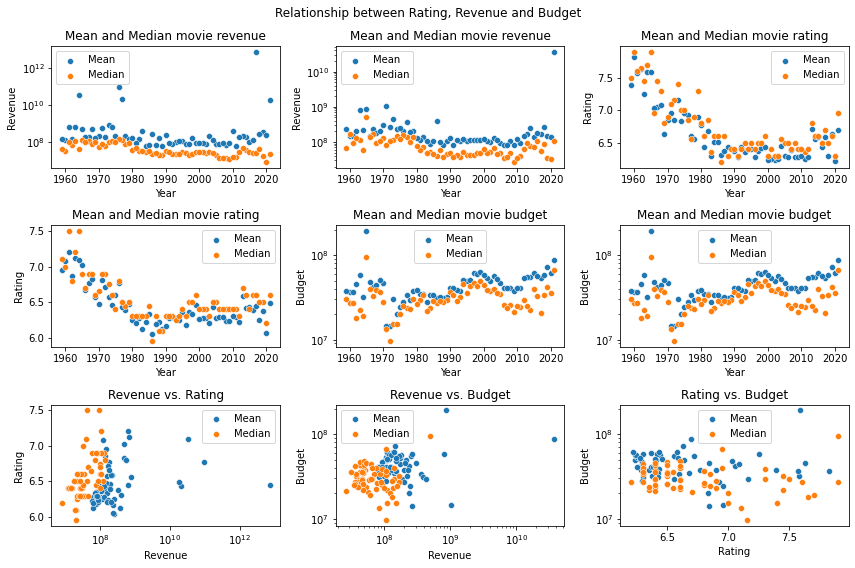

In [6]:
fig, ax = plt.subplots(3, 3, figsize=(12,8))
fig.suptitle('Relationship between Rating, Revenue and Budget')

# Revenue vs. Rating
fig00=sns.scatterplot(ax = ax[0,0],x=years_rr, y=mean_revenue_rr,label='Mean')
fig00=sns.scatterplot(ax = ax[0,0],x=years_rr, y=median_revenue_rr,label='Median')
fig00.set(yscale="log")
ax[0,0].set_title('Mean and Median movie revenue')
fig00.set_xlabel('Year')
fig00.set_ylabel('Revenue')

fig10=sns.scatterplot(ax = ax[1,0], x=years_rr, y=mean_rating_rr,label='Mean')
fig10=sns.scatterplot(ax = ax[1,0], x=years_rr, y=median_rating_rr,label='Median')
ax[1,0].set_title('Mean and Median movie rating')
fig10.set_xlabel('Year')
fig10.set_ylabel('Rating')

fig20=sns.scatterplot(ax = ax[2,0], x=mean_revenue_rr, y=mean_rating_rr,label='Mean')
fig20=sns.scatterplot(ax = ax[2,0], x=median_revenue_rr, y=median_rating_rr,label='Median')
ax[2,0].set_title('Revenue vs. Rating')
fig20.set(xscale="log")
fig20.set_xlabel('Revenue')
fig20.set_ylabel('Rating')

# Revenue vs. Budget
fig01=sns.scatterplot(ax = ax[0,1],x=years_rb, y=mean_revenue_rb,label='Mean')
fig01=sns.scatterplot(ax = ax[0,1],x=years_rb, y=median_revenue_rb,label='Median')
fig01.set(yscale="log")
ax[0,1].set_title('Mean and Median movie revenue')
fig01.set_xlabel('Year')
fig01.set_ylabel('Revenue')

fig11=sns.scatterplot(ax = ax[1,1], x=years_rb, y=mean_budget_rb,label='Mean')
fig11 = sns.scatterplot(ax = ax[1,1], x=years_rb, y=median_budget_rb,label='Median')
fig11.set(yscale="log")
ax[1,1].set_title('Mean and Median movie budget')
fig11.set_xlabel('Year')
fig11.set_ylabel('Budget')

fig21=sns.scatterplot(ax = ax[2,1], x=mean_revenue_rb, y=mean_budget_rb,label='Mean')
fig21=sns.scatterplot(ax = ax[2,1], x=median_revenue_rb, y=median_budget_rb,label='Median')
ax[2,1].set_title('Revenue vs. Budget')
fig21.set(xscale="log")
fig21.set(yscale="log")
fig21.set_xlabel('Revenue')
fig21.set_ylabel('Budget')

# Rating vs. Budget
fig02=sns.scatterplot(ax = ax[0,2],x=years_rab, y=mean_rating_rab,label='Mean')
fig02=sns.scatterplot(ax = ax[0,2],x=years_rab, y=median_rating_rab,label='Median')
ax[0,2].set_title('Mean and Median movie rating')
fig02.set_xlabel('Year')
fig02.set_ylabel('Rating')

fig12=sns.scatterplot(ax = ax[1,2], x=years_rab, y=mean_budget_rab,label='Mean')
fig12 = sns.scatterplot(ax = ax[1,2], x=years_rab, y=median_budget_rab,label='Median')
fig12.set(yscale="log")
ax[1,2].set_title('Mean and Median movie budget')
fig12.set_xlabel('Year')
fig12.set_ylabel('Budget')

fig22=sns.scatterplot(ax = ax[2,2], x=mean_rating_rab, y=mean_budget_rab,label='Mean')
fig22=sns.scatterplot(ax = ax[2,2], x=median_rating_rab, y=median_budget_rab,label='Median')
ax[2,2].set_title('Rating vs. Budget')
fig22.set(yscale="log")
fig22.set_xlabel('Rating')
fig22.set_ylabel('Budget')

fig.tight_layout() 


In [4]:
#Revenue, Rating and Budget
df = df_movie.copy()
df = df.dropna(subset=['inflation corrected revenue', 'averageRating','inflation corrected budget'])

years = df['Movie release date'].unique()
mean_revenue = np.zeros_like(years)
median_revenue = np.zeros_like(years)
mean_rating = np.zeros_like(years)
median_rating = np.zeros_like(years)
mean_budget = np.zeros_like(years)
median_budget = np.zeros_like(years)

for i,y in enumerate(years):
    
    rev = df.loc[df['Movie release date'] == y]['inflation corrected revenue']
    rat = df.loc[df['Movie release date'] == y]['averageRating']
    bud = df.loc[df['Movie release date'] == y]['inflation corrected budget']
    
    mean = np.mean(rev)
    median = np.median(rev)
    mean_revenue[i] = mean
    median_revenue[i] = median
    
    mean = np.mean(rat)
    median = np.median(rat)
    mean_rating[i] = mean
    median_rating[i] = median
    
    mean = np.mean(bud)
    median = np.median(bud)
    mean_budget[i] = mean
    median_budget[i] = median

In [11]:
# Create a dataframe that will store our final result
df_pair = pd.DataFrame(columns=['revenue','budget','rating','Type'])

In [13]:
df_pair.revenue = np.log(np.concatenate((mean_revenue,median_revenue)))

In [14]:
df_pair.rating = np.concatenate((mean_rating,median_rating))

In [15]:
df_pair.budget = np.log(np.concatenate((mean_budget,median_budget)))

In [16]:
type_mean = np.empty(len(years), dtype='object')
type_mean.fill('Mean')
type_median = np.empty(len(years), dtype='object')
type_median.fill('Median')

df_pair.Type = np.concatenate((type_mean,type_median))

In [17]:
df_pair

revenue     budget    rating    Type
0    19.355314  17.833060  6.552688    Mean
1    18.720612  17.941814  6.581081    Mean
2    18.963580  17.786481  6.585556    Mean
3    19.000396  17.843589  6.436634    Mean
4    18.955136  17.837124  6.716667    Mean
..         ...        ...       ...     ...
121  17.371865  17.028500  6.400000  Median
122  18.017406  17.214444  7.500000  Median
123  17.951303  17.200081  6.400000  Median
124  17.284679  17.387780  6.300000  Median
125  18.480495  18.020203  6.950000  Median

[126 rows x 4 columns]

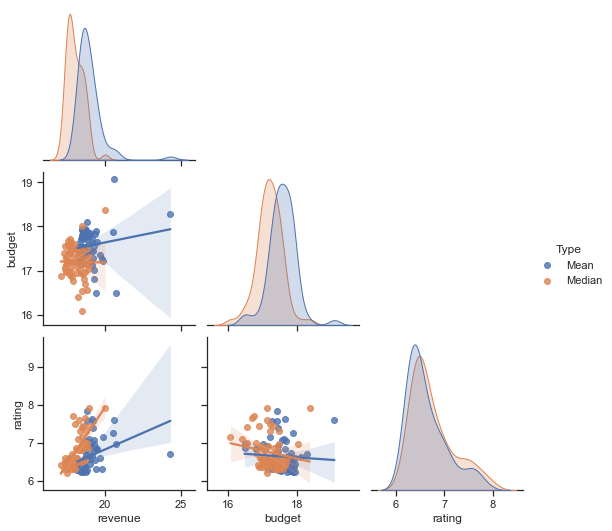

In [29]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.pairplot(df_pair, hue="Type",kind='reg',corner=True)
plt.show()

In [44]:
df[['inflation corrected revenue','inflation corrected budget','averageRating']]

inflation corrected revenue  inflation corrected budget  \
33                      4.692887e+06                4.578426e+06   
231                     2.694641e+08                7.431127e+07   
465                     1.236175e+06                3.891662e+06   
491                     6.092958e+08                1.543388e+08   
518                     1.780728e+08                5.030301e+07   
...                              ...                         ...   
9072785                 1.717332e+07                1.500000e+07   
9121300                 6.118657e+07                2.500000e+07   
9134724                 2.245433e+08                1.500000e+08   
9334308                 3.391781e+05                2.093957e+07   
9349540                 7.204153e+06                2.093957e+07   

         averageRating  
33                 7.6  
231                7.0  
465                6.7  
491                8.0  
518                7.8  
...                ...  
9072785            6.6  
9121300            5.9  
9134724            7.4  
9334308            5.5  
9349540            6.3  

[5025 rows x 3 columns]

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.pairplot(df[['inflation corrected revenue','inflation corrected budget','averageRating']],kind='reg',corner=True)
plt.show()

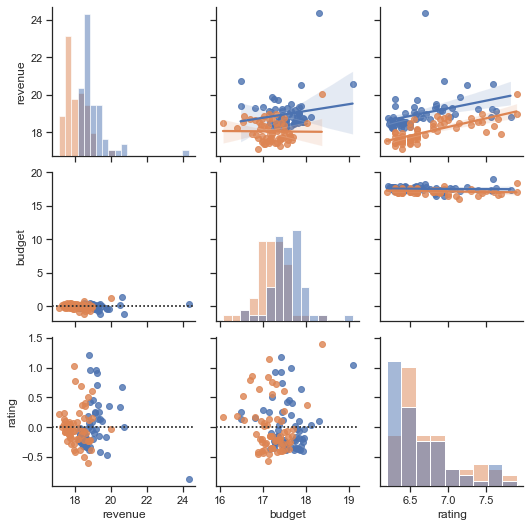

In [30]:

sns.set_theme(style="ticks")

g = sns.PairGrid(df_pair, hue="Type")
g.map_upper(sns.regplot)
g.map_lower(sns.residplot)
g.map_diag(sns.histplot)
plt.show()

Let's try to display some statistics on the selected features. We now compute the Pearson coefficient for each of the rating, revenue, budget combination, for both the mean and the median.

In [76]:
print(f'Pearson correlation between the mean of revenue and the mean of rating: {stats.pearsonr(mean_revenue_rr,mean_rating_rr)}')
print(f'Pearson correlation between the median of revenue and the median of rating: {stats.pearsonr(median_revenue_rr,median_rating_rr)}\n')

print(f'Pearson correlation between the mean of revenue and the mean of budget: {stats.pearsonr(mean_revenue_rb,mean_budget_rb)}')
print(f'Pearson correlation between the median of revenue and the median of budget: {stats.pearsonr(median_revenue_rb,median_budget_rb)}\n')

print(f'Pearson correlation between the mean of rating and the mean of budget: {stats.pearsonr(mean_rating_rab,mean_budget_rab)}')
print(f'Pearson correlation between the median of rating and the median of budget: {stats.pearsonr(median_rating_rab,median_budget_rab)}')

Pearson correlation between the mean of revenue and the mean of rating: (0.3245392913873216, 0.00945853846238661)
Pearson correlation between the median of revenue and the median of rating: (0.5684130132132093, 1.1763214541630288e-06)

Pearson correlation between the mean of revenue and the mean of budget: (0.2413953957057724, 0.056658092137997156)
Pearson correlation between the median of revenue and the median of budget: (0.4214180215223112, 0.0005825398420519009)

Pearson correlation between the mean of rating and the mean of budget: (0.11003060782285895, 0.3906368475416801)
Pearson correlation between the median of rating and the median of budget: (-0.01028190497335666, 0.9362548057427648)


## An overview of rating and revenue

The rating is represented in the column 'averageRating' and it ranges from 0 to 10, where 10 is the best score and 0 is the lowest.

Since we want to consider both the rating and the revenu at the same time, we remove the rows that have NaN in the column 'averageRating' or 'Movie box office revenue'.

In [10]:
revenue = df_movie.copy()
revenue = revenue.dropna(subset=['Movie box office revenue', 'averageRating'])
#revenue = revenue[revenue['Movie box office revenue'].notna()]
#revenue = revenue[revenue['averageRating'].notna()]

In [11]:
revenue['averageRating'].describe()

count    9575.000000
mean        6.352324
std         1.022347
min         1.000000
25%         5.800000
50%         6.400000
75%         7.000000
max         9.300000
Name: averageRating, dtype: float64

In [12]:
revenue.head()

Freebase movie ID    IMDB_id  Movie box office revenue  \
9         /m/0100blym  tt1441953                 1800000.0   
33        /m/0100khzv  tt2802154                 4100000.0   
231       /m/0105j_71  tt3079380               235700000.0   
303       /m/0106bp29  tt3286560                 1200000.0   
465       /m/0109gmqq  tt3013602                 1080000.0   

                    Movie genres names          Movie name  \
9    ['Biography', 'Drama', 'History']  Testament of Youth   
33                  ['Crime', 'Drama']           Leviathan   
231               ['Action', 'Comedy']                 Spy   
303        ['Drama', 'Romance', 'War']       The Last Face   
465                         ['Comedy']         Babysitting   

     Movie release date  averageRating      budget  numVotes prod_country  \
9                2014.0            7.2         NaN   29155.0           GB   
33               2014.0            7.6   4000000.0   53841.0           RU   
231              2015.0            7.0  65000000.0  245850.0           US   
303              2016.0            4.9         NaN    5158.0           US   
465              2014.0            6.7   3400000.0   10759.0          NaN   

     inflation coeff  inflation corrected revenue  inflation corrected budget  
9           1.144606                 2.060292e+06                         NaN  
33          1.144606                 4.692887e+06                4.578426e+06  
231         1.143250                 2.694641e+08                7.431127e+07  
303         1.129007                 1.354808e+06                         NaN  
465         1.144606                 1.236175e+06                3.891662e+06

### Plots

Let's plot the variables!

In [13]:
years = revenue['Movie release date'].unique()
mean_revenue = np.zeros_like(years)
median_revenue = np.zeros_like(years)
mean_rating = np.zeros_like(years)
median_rating = np.zeros_like(years)
for i,y in enumerate(years):
    
    rev = revenue.loc[revenue['Movie release date'] == y]['Movie box office revenue']
    rat = revenue.loc[revenue['Movie release date'] == y]['averageRating']
    
    mean = np.mean(rev)
    median = np.median(rev)
    mean_revenue[i] = mean
    median_revenue[i] = median
    
    mean = np.mean(rat)
    median = np.median(rat)
    mean_rating[i] = mean
    median_rating[i] = median

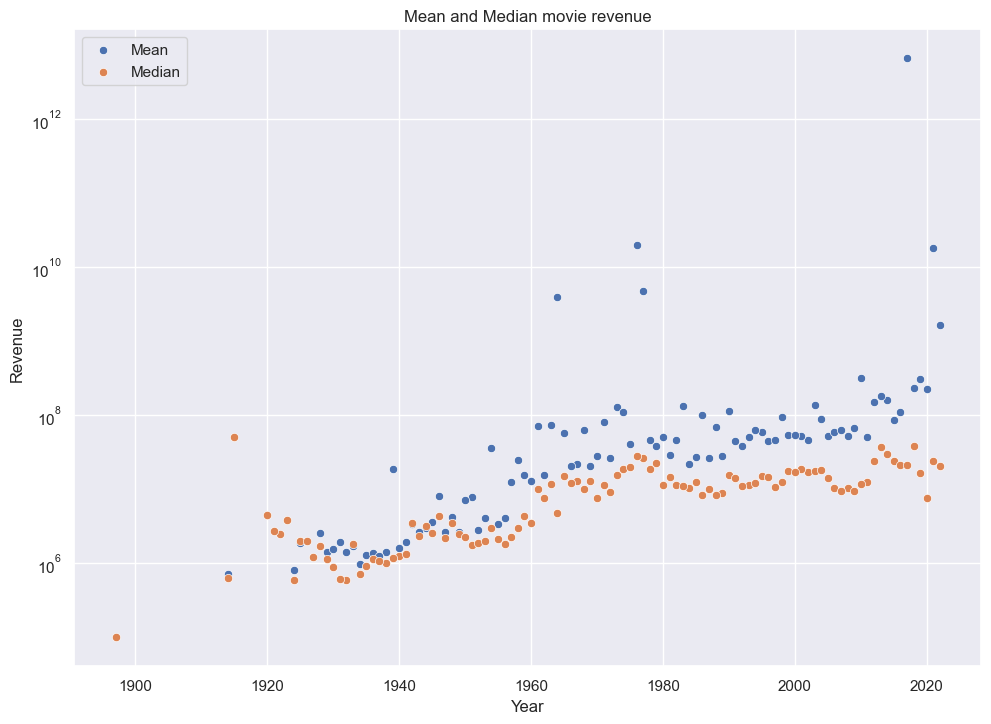

In [15]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
splot = sns.scatterplot(x=years, y=mean_revenue,label='Mean')
splot = sns.scatterplot(x=years, y=median_revenue,label='Median')
splot.set(yscale="log")
plt.title('Mean and Median movie revenue')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.show()

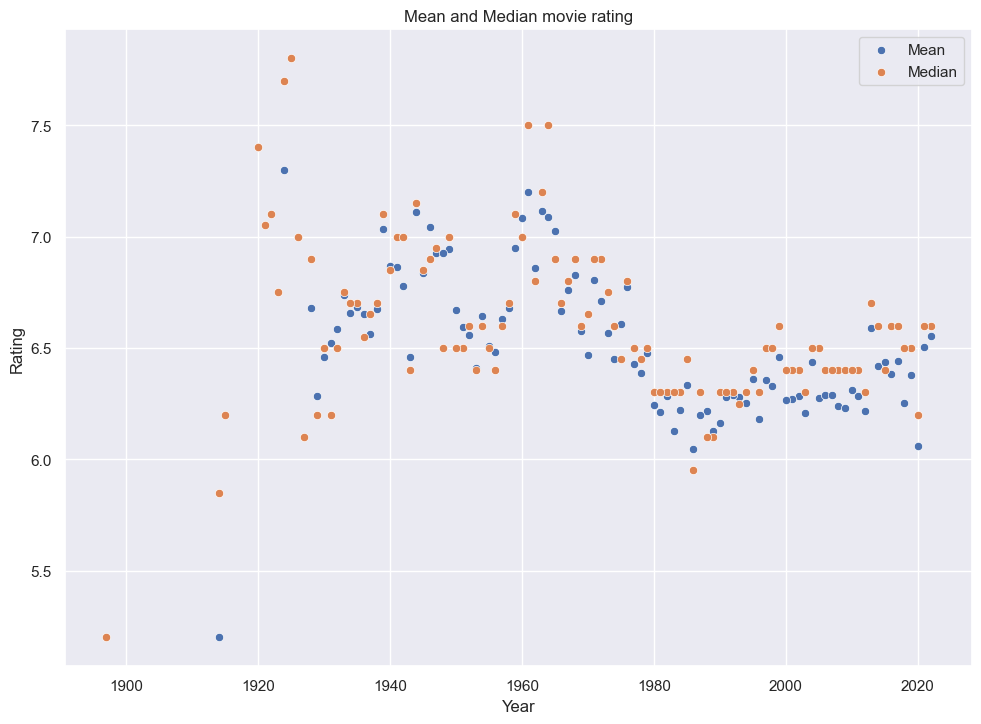

In [16]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
splot = sns.scatterplot(x=years, y=mean_rating,label='Mean')
splot = sns.scatterplot(x=years, y=median_rating,label='Median')
plt.title('Mean and Median movie rating')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.show()

Let's try to do some statistics. It seems that the mean rating and the mean revenue are not linearly correlated. The median values seem to be significantly correlated but the coefficient is quite small (-0.2).

In [17]:
stats.pearsonr(mean_rating,mean_revenue)

(-0.0243641609838837, 0.8042064089301088)

In [18]:
stats.pearsonr(median_rating,median_revenue)

(-0.2031754761640116, 0.0367206084808511)

In order to really draw conclusion we should take into consideration the inflation!

In [19]:
inflation_revenue = revenue.dropna(subset=['inflation coeff'])

In [20]:
inflation_years = inflation_revenue['Movie release date'].unique()
inflation_mean_revenue = np.zeros_like(inflation_years)
inflation_median_revenue = np.zeros_like(inflation_years)
inflation_mean_rating = np.zeros_like(inflation_years)
inflation_median_rating = np.zeros_like(inflation_years)
for i,y in enumerate(inflation_years):
    
    rev = inflation_revenue.loc[inflation_revenue['Movie release date'] == y]['inflation corrected revenue']
    rat = inflation_revenue.loc[inflation_revenue['Movie release date'] == y]['averageRating']
    
    mean = np.mean(rev)
    median = np.median(rev)
    inflation_mean_revenue[i] = mean
    inflation_median_revenue[i] = median
    
    mean = np.mean(rat)
    median = np.median(rat)
    inflation_mean_rating[i] = mean
    inflation_median_rating[i] = median

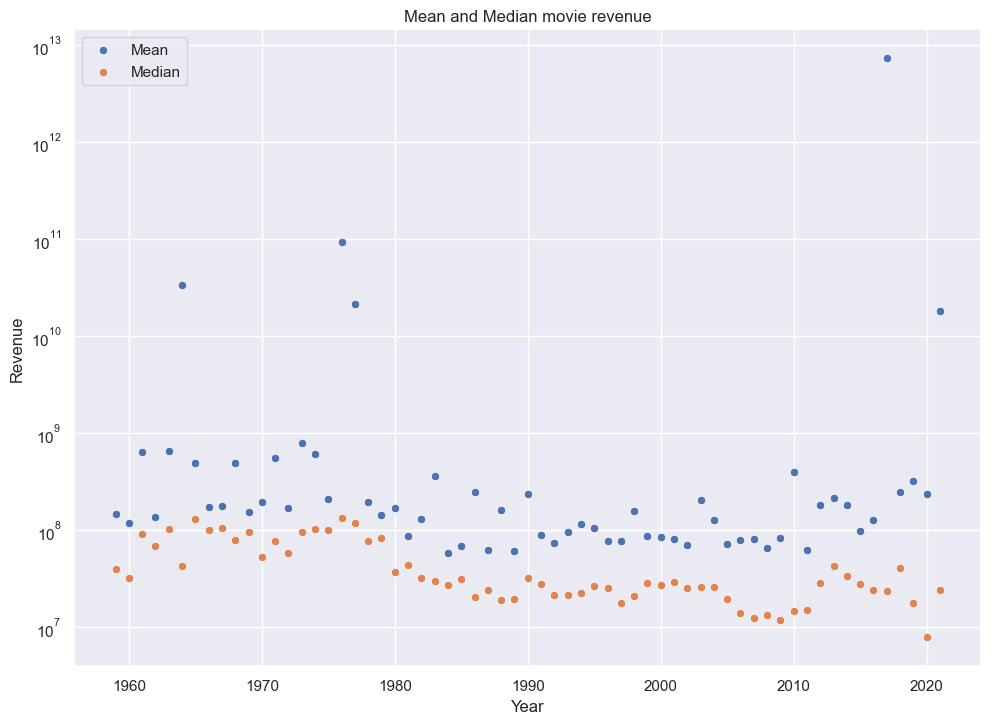

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
splot = sns.scatterplot(x=inflation_years, y=inflation_mean_revenue,label='Mean')
splot = sns.scatterplot(x=inflation_years, y=inflation_median_revenue,label='Median')
splot.set(yscale="log")
plt.title('Mean and Median movie revenue')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.show()

The plot of the revenues corrected with inflation now shows us a more flat regime that without inflation. We can clearly identify some outlines. As a future study it can be nice to analyse which these movies are and why they have such a high revenue.

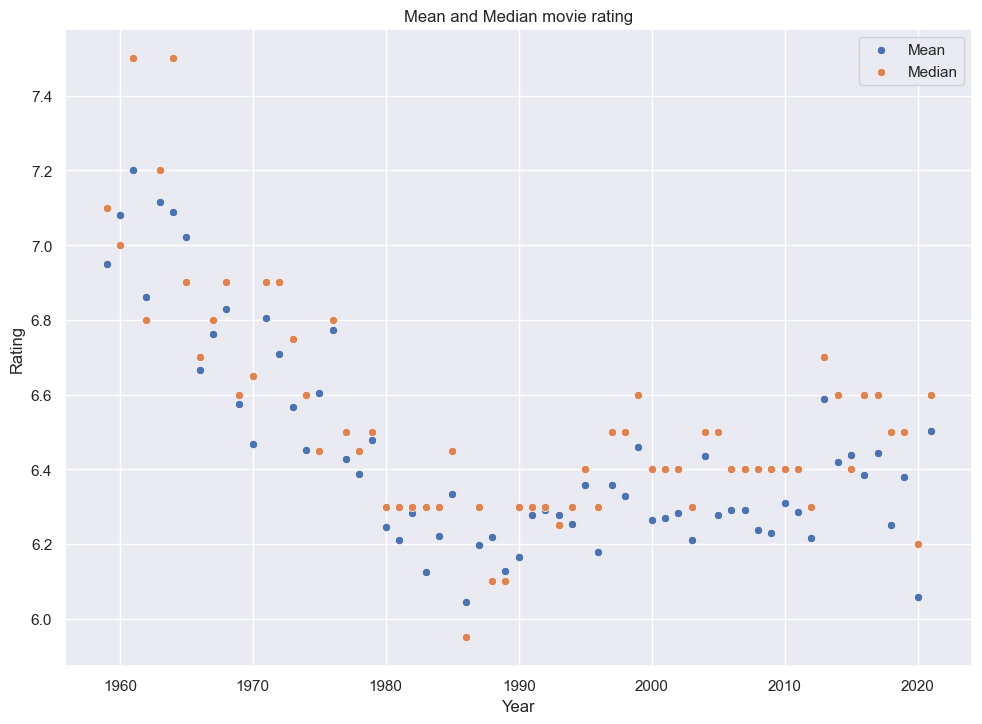

In [22]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
splot = sns.scatterplot(x=inflation_years, y=inflation_mean_rating,label='Mean')
splot = sns.scatterplot(x=inflation_years, y=inflation_median_rating,label='Median')
plt.title('Mean and Median movie rating')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.show()

Let's try to do some statistics on the corrected revenues. It seems that the mean rating and the mean revenue are not linearly correlated. The median values seem to be significantly correlated with a quite high coefficient (0.54). This gives us the idea that the high revenue is correlated with high rating.

In [23]:
stats.pearsonr(inflation_mean_rating,inflation_mean_revenue)

(0.0037690648999040167, 0.9766117291217751)

In [24]:
stats.pearsonr(inflation_median_rating,inflation_median_revenue)

(0.5345058424937269, 6.414122291842158e-06)

## An overview of rating and budget

We want to analyse if the budget and the rating score are correlated.

In [38]:
budget_rating = df_movie.copy()
budget_rating = budget_rating.dropna(subset=['budget', 'averageRating'])


In [41]:
years = budget_rating['Movie release date'].unique()
mean_budget = np.zeros_like(years)
median_budget = np.zeros_like(years)
mean_rating = np.zeros_like(years)
median_rating = np.zeros_like(years)
for i,y in enumerate(years):
    
    bud = budget_rating.loc[budget_rating['Movie release date'] == y]['budget']
    rat = budget_rating.loc[budget_rating['Movie release date'] == y]['averageRating']
    
    mean = np.mean(bud)
    median = np.median(bud)
    mean_budget[i] = mean
    median_budget[i] = median
    
    mean = np.mean(rat)
    median = np.median(rat)
    mean_rating[i] = mean
    median_rating[i] = median

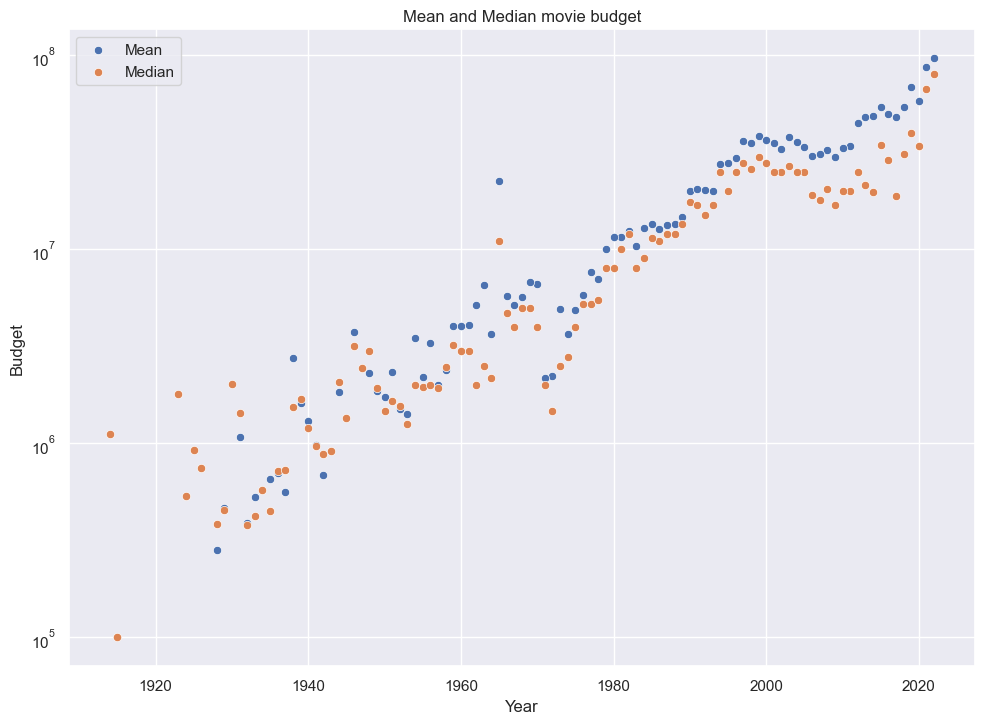

In [43]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
splot = sns.scatterplot(x=years, y=mean_budget,label='Mean')
splot = sns.scatterplot(x=years, y=median_budget,label='Median')
splot.set(yscale="log")
plt.title('Mean and Median movie budget')
plt.xlabel('Year')
plt.ylabel('Budget')
plt.show()

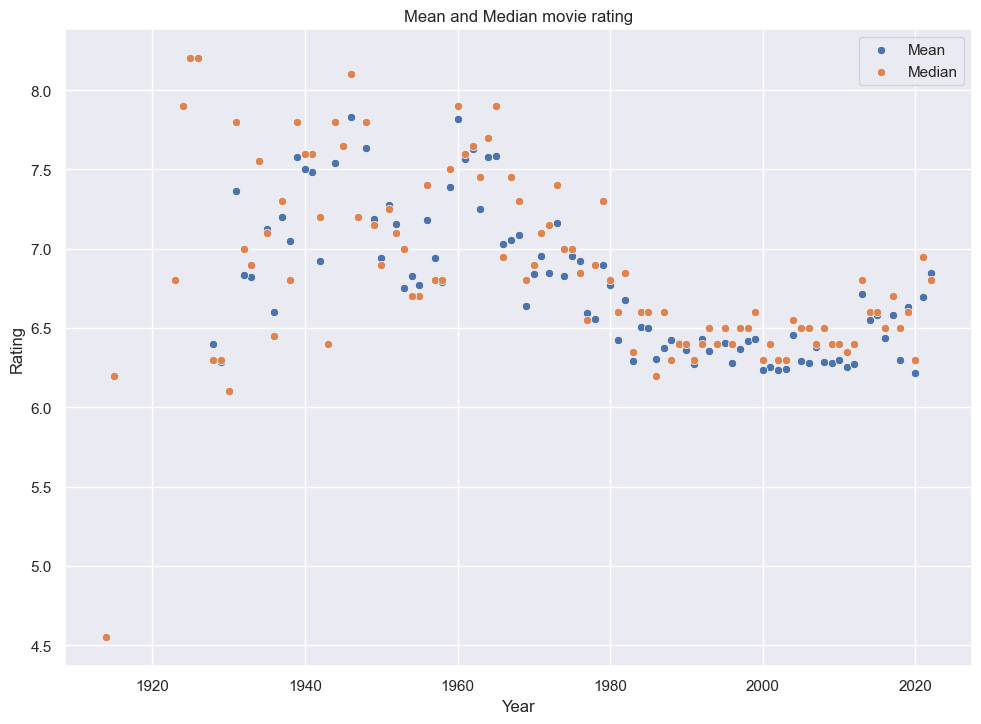

In [44]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
splot = sns.scatterplot(x=years, y=mean_rating,label='Mean')
splot = sns.scatterplot(x=years, y=median_rating,label='Median')
plt.title('Mean and Median movie rating')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.show()

In [52]:
print(f'Pearson correlation between the mean of rating and the mean of budget: {stats.pearsonr(mean_rating,mean_budget)}')
print(f'Pearson correlation between the median of rating and the median of budget: {stats.pearsonr(median_rating,median_budget)}')

Pearson correlation between the mean of rating and the mean of budget: (-0.4014097909076749, 3.178640752012932e-05)
Pearson correlation between the median of rating and the median of budget: (-0.3689506457988959, 0.0001466874375292228)


The negative correlation between the budget and the rating is perceived. In both case, they are significant.

We consider now the inflation:

In [45]:
budget_rating_inflation = df_movie.copy()
budget_rating_inflation = budget_rating_inflation.dropna(subset=['inflation corrected budget', 'averageRating'])

In [48]:
years_inflation = budget_rating_inflation['Movie release date'].unique()
mean_budget_inflation = np.zeros_like(years_inflation)
median_budget_inflation = np.zeros_like(years_inflation)
mean_rating_inflation = np.zeros_like(years_inflation)
median_rating_inflation = np.zeros_like(years_inflation)
for i,y in enumerate(years_inflation):
    
    bud = budget_rating.loc[budget_rating['Movie release date'] == y]['inflation corrected budget']
    rat = budget_rating.loc[budget_rating['Movie release date'] == y]['averageRating']
    
    mean = np.mean(bud)
    median = np.median(bud)
    mean_budget_inflation[i] = mean
    median_budget_inflation[i] = median
    
    mean = np.mean(rat)
    median = np.median(rat)
    mean_rating_inflation[i] = mean
    median_rating_inflation[i] = median

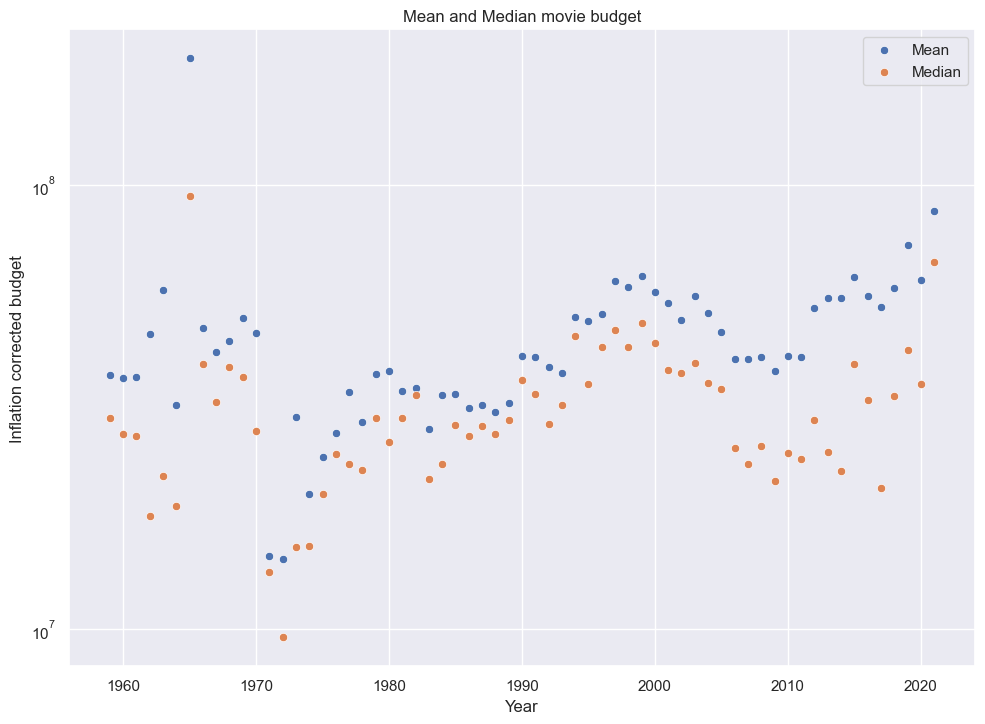

In [49]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
splot = sns.scatterplot(x=years_inflation, y=mean_budget_inflation,label='Mean')
splot = sns.scatterplot(x=years_inflation, y=median_budget_inflation,label='Median')
splot.set(yscale="log")
plt.title('Mean and Median movie budget')
plt.xlabel('Year')
plt.ylabel('Inflation corrected budget')
plt.show()

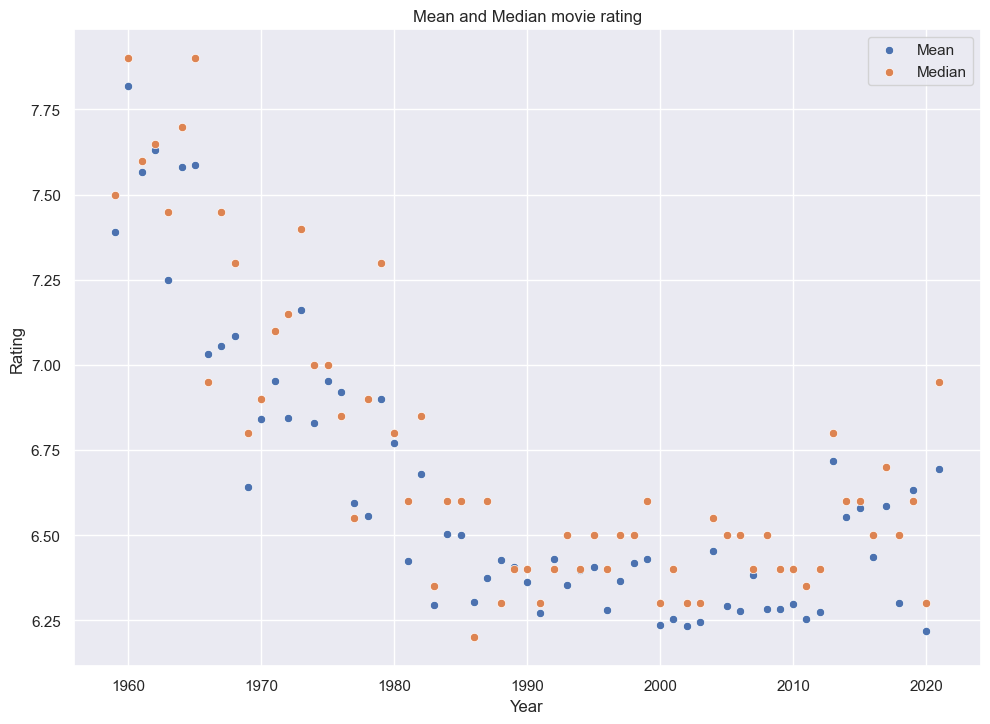

In [51]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
splot = sns.scatterplot(x=years_inflation, y=mean_rating_inflation,label='Mean')
splot = sns.scatterplot(x=years_inflation, y=median_rating_inflation,label='Median')
plt.title('Mean and Median movie rating')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.show()

In [53]:
print(f'Pearson correlation between the mean of rating and the mean of budget: {stats.pearsonr(mean_rating_inflation,mean_budget_inflation)}')
print(f'Pearson correlation between the median of rating and the median of budget: {stats.pearsonr(median_rating_inflation,median_budget_inflation)}')

Pearson correlation between the mean of rating and the mean of budget: (0.11013096349258317, 0.3902021676321296)
Pearson correlation between the median of rating and the median of budget: (-0.01028190497335666, 0.9362548057427648)


Once the inflation considered, no significant correlation is computed.

## An overview of revenue and budget

We want to analyse if the budget and the revenue are correlated.

In [55]:
budget_revenue = df_movie.copy()
budget_revenue = budget_revenue.dropna(subset=['budget', 'Movie box office revenue'])


In [64]:
years = budget_revenue['Movie release date'].unique()
mean_budget = np.zeros_like(years)
median_budget = np.zeros_like(years)
mean_revenue = np.zeros_like(years)
median_revenue = np.zeros_like(years)
for i,y in enumerate(years):
    
    bud = budget_revenue.loc[budget_revenue['Movie release date'] == y]['budget']
    rev = budget_revenue.loc[budget_revenue['Movie release date'] == y]['Movie box office revenue']
    
    mean = np.mean(bud)
    median = np.median(bud)
    mean_budget[i] = mean
    median_budget[i] = median
    
    mean = np.mean(rev)
    median = np.median(rev)
    mean_revenue[i] = mean
    median_revenue[i] = median

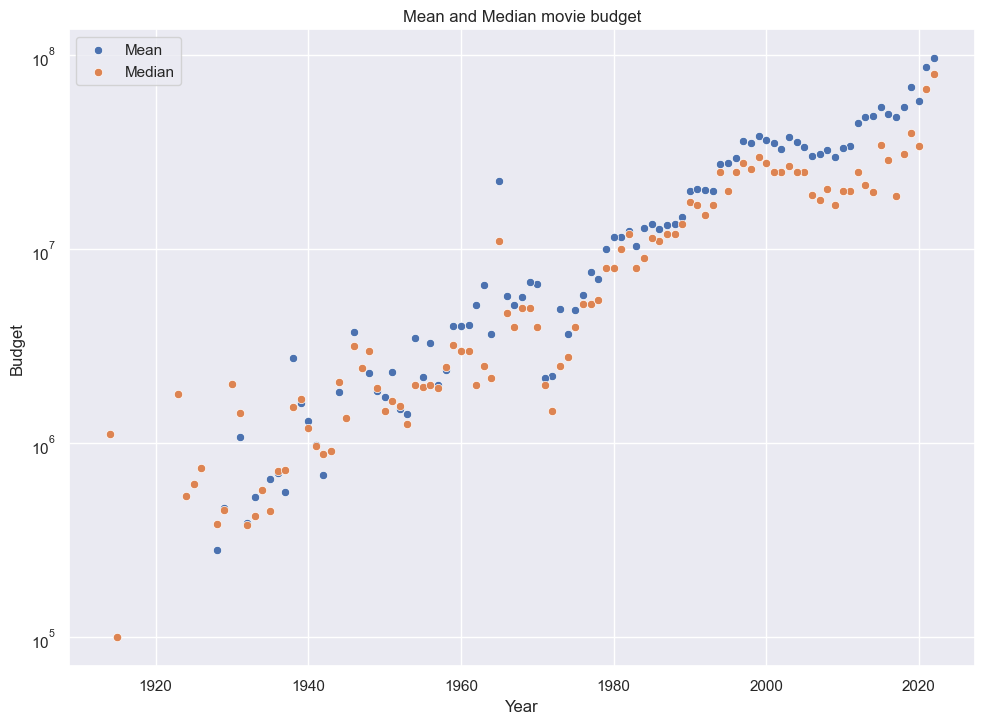

In [65]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
splot = sns.scatterplot(x=years, y=mean_budget,label='Mean')
splot = sns.scatterplot(x=years, y=median_budget,label='Median')
splot.set(yscale="log")
plt.title('Mean and Median movie budget')
plt.xlabel('Year')
plt.ylabel('Budget')
plt.show()

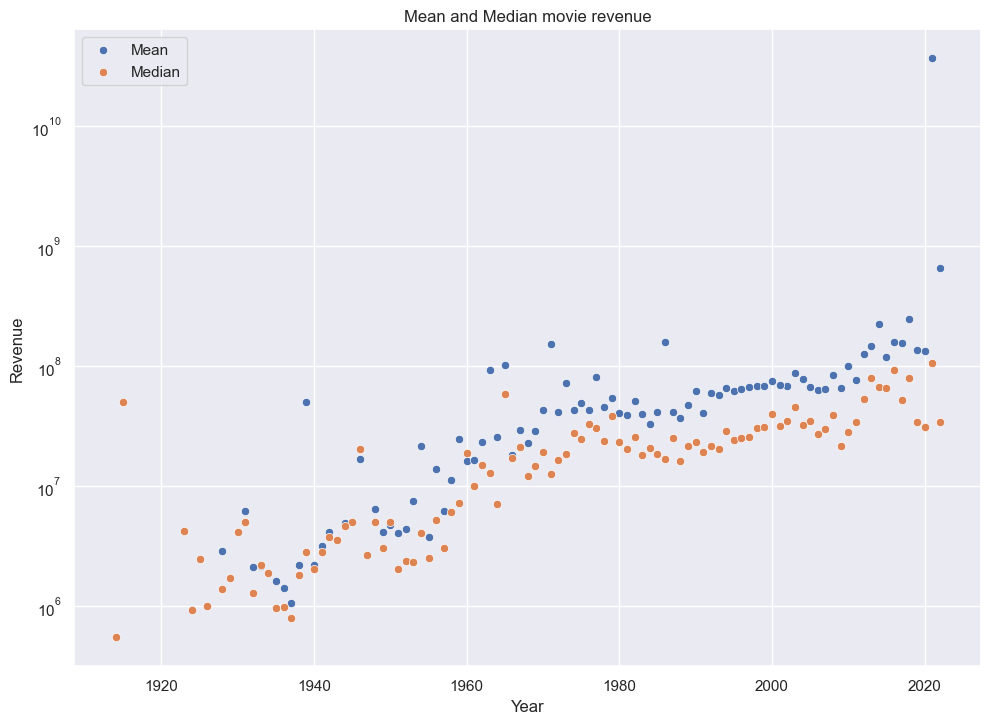

In [66]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
splot = sns.scatterplot(x=years, y=mean_revenue,label='Mean')
splot = sns.scatterplot(x=years, y=median_revenue,label='Median')
splot.set(yscale="log")
plt.title('Mean and Median movie revenue')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.show()

In [67]:
print(f'Pearson correlation between the mean of revenue and the mean of budget: {stats.pearsonr(mean_revenue,mean_budget)}')
print(f'Pearson correlation between the median of revenue and the median of budget: {stats.pearsonr(median_revenue,median_budget)}')

Pearson correlation between the mean of revenue and the mean of budget: (0.3733823199790379, 0.00012016275675333612)
Pearson correlation between the median of revenue and the median of budget: (0.7064360611788824, 1.5469515778139328e-16)


With inflation consideration:

In [68]:
budget_revenue_inflation = df_movie.copy()
budget_revenue_inflation = budget_revenue_inflation.dropna(subset=['inflation corrected budget', 'inflation corrected revenue'])

In [70]:
years_inflation = budget_revenue_inflation['Movie release date'].unique()
mean_budget_inflation = np.zeros_like(years_inflation)
median_budget_inflation = np.zeros_like(years_inflation)
mean_revenue_inflation = np.zeros_like(years_inflation)
median_revenue_inflation = np.zeros_like(years_inflation)
for i,y in enumerate(years_inflation):
    
    bud = budget_revenue_inflation.loc[budget_revenue_inflation['Movie release date'] == y]['inflation corrected budget']
    rev = budget_revenue_inflation.loc[budget_revenue_inflation['Movie release date'] == y]['inflation corrected revenue']
    
    mean = np.mean(bud)
    median = np.median(bud)
    mean_budget_inflation[i] = mean
    median_budget_inflation[i] = median
    
    mean = np.mean(rev)
    median = np.median(rev)
    mean_revenue_inflation[i] = mean
    median_revenue_inflation[i] = median

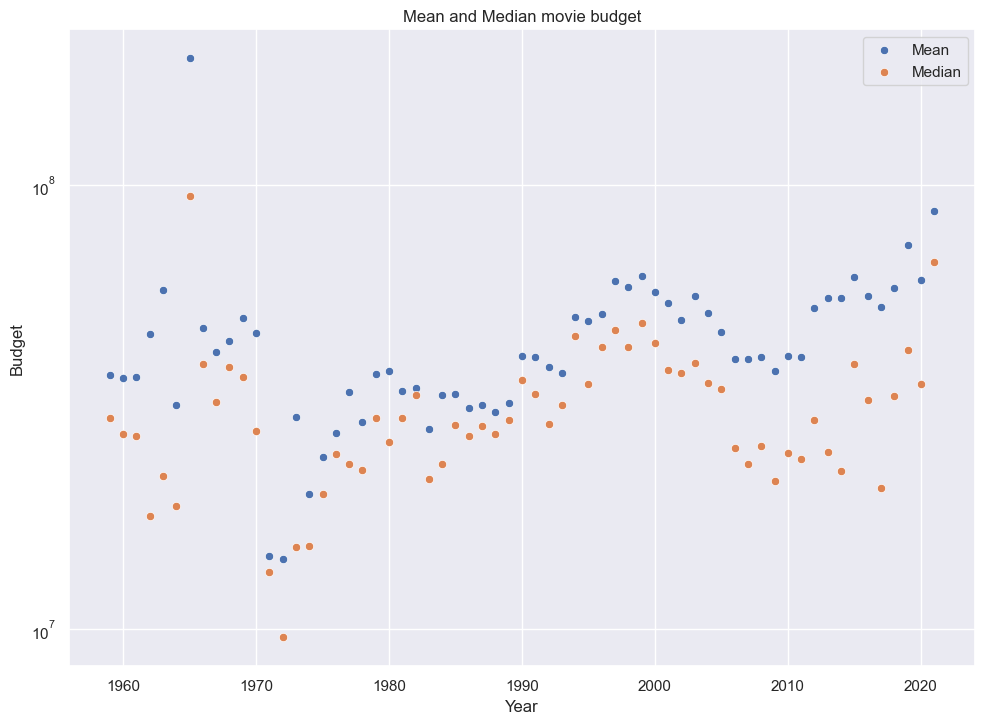

In [72]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
splot = sns.scatterplot(x=years_inflation, y=mean_budget_inflation,label='Mean')
splot = sns.scatterplot(x=years_inflation, y=median_budget_inflation,label='Median')
splot.set(yscale="log")
plt.title('Mean and Median movie budget')
plt.xlabel('Year')
plt.ylabel('Budget')
plt.show()

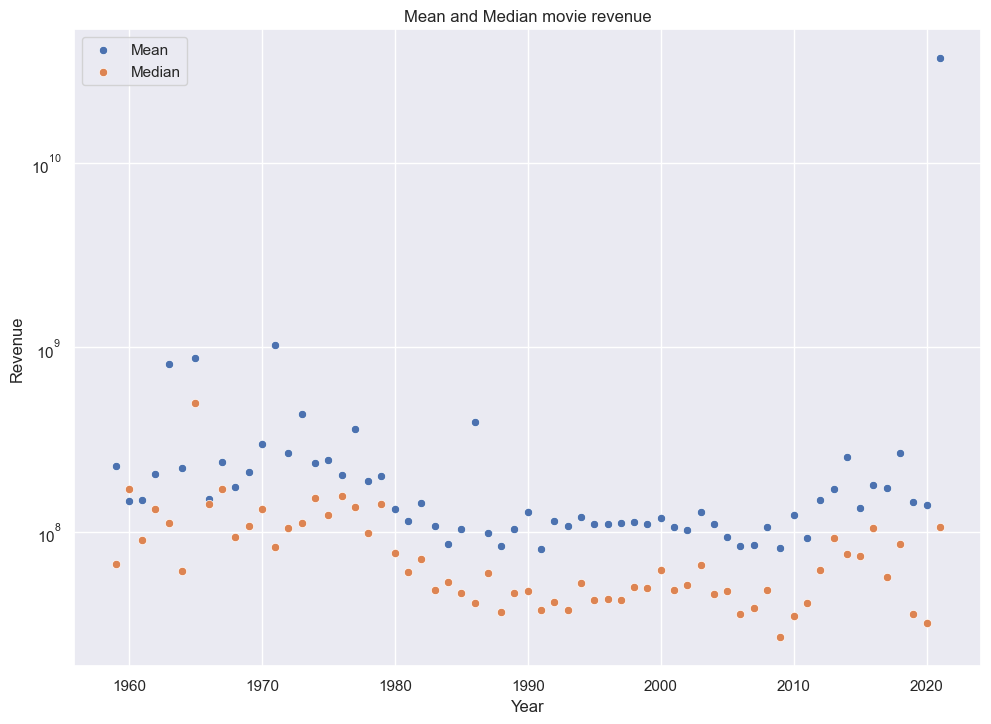

In [74]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
splot = sns.scatterplot(x=years_inflation, y=mean_revenue_inflation,label='Mean')
splot = sns.scatterplot(x=years_inflation, y=median_revenue_inflation,label='Median')
splot.set(yscale="log")
plt.title('Mean and Median movie revenue')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.show()

In [75]:
print(f'Pearson correlation between the mean of revenue and the mean of budget: {stats.pearsonr(mean_revenue_inflation,mean_budget_inflation)}')
print(f'Pearson correlation between the median of revenue and the median of budget: {stats.pearsonr(median_revenue_inflation,median_budget_inflation)}')

Pearson correlation between the mean of revenue and the mean of budget: (0.2413787628531989, 0.05667565728783349)
Pearson correlation between the median of revenue and the median of budget: (0.4214180215223112, 0.0005825398420519009)


### Pearson correlation without mean/median

### Plots with bootstrap